# NGRAM HDC METHOD

In [1]:
# Import Basic Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from os import listdir

## Data Insights and Pre-Processing

In [2]:
### Function: Collects sample data from files in Stanford Dataset Subfolders
    ## Inputs: folderpath: Path to Desired Folder
    ##         sentiment:  Sentiment Value (0 or 1)
    ## Output: df: Pandas Dataframe of all Sample Data found in desired folder
def stanfordDatasetFolderDataLoader(folderpath, sentiment):
    file_list=listdir(folderpath)

    df = pd.DataFrame(columns = ['Review', 'Sentiment'])
    for file in file_list:
        filepath=folderpath + file
        f = open(filepath,'r', encoding="utf-8")
        sample = f.read()
        f.close()
        df = df.append({'Review' : sample, 'Sentiment' : sentiment}, ignore_index = True)
    return df

# Choose Dataset (0: Sentiment140, 1: Stanford IMBD Dataset)
dataset = 0

# Load Dataset
if (dataset==0):
    print('Using Sentiment140 Twitter Dataset...')
    # Read in Sentiment140 data from CSV
    df = pd.read_csv('./Sentiment140_Tweets/data.csv')
    df.columns =['Sentiment', 'IDs', 'Date', 'Flag', 'User', 'Tweet']
else:
    print('Using Stanford IMBD Movie Review Dataset...')
    # Read in Training Stanford IMBD Movie Review data from subfolders
    train_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/train/pos/',1)
    train_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/train/neg/',0)
    train_df=pd.concat([train_pos, train_neg], axis=0)
    
    # Read in Testing Stanford IMBD Movie Review data from subfolders
    test_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/test/pos/',1)
    test_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/test/neg/',0)
    test_df=pd.concat([test_pos, test_neg], axis=0)

    df=pd.concat([train_df, test_df], axis=0)
print('Total number of Samples In Dataset:', len(df))

Using Sentiment140 Twitter Dataset...
Total number of Samples In Dataset: 1599999


In [3]:
# Dataset Cleanup:

# Sentiment140 Sentiment Clean Up
if dataset==0:
    # Replace Sentiment of 4 (Positive) with 1
    df["Sentiment"].replace({4: 1}, inplace=True)
    # Eliminate Neutral Tweets, if any
    df = df[df['Sentiment'] != 2]

# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Dataset in Use has No NULL values.")
else:
    df.dropna(inplace=True)

print("Dataset Length after Cleanup:", len(df))

Dataset in Use has No NULL values.
Dataset Length after Cleanup: 1599999


In [4]:
# Downsample the Dataset to 5000 Total Samples
percentage=5000/len(df)
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Sentiment,IDs,Date,Flag,User,Tweet
1016244,1,1881672289,Fri May 22 05:16:44 PDT 2009,NO_QUERY,viry_trivium,"Happy birthday, sister!"
1303317,1,2009051656,Tue Jun 02 15:04:22 PDT 2009,NO_QUERY,Earlthedog,Just finished eating supper and now I am attac...
576684,0,2211886069,Wed Jun 17 13:24:27 PDT 2009,NO_QUERY,StefyyMarie,i hate love right now.
837327,1,1558734942,Sun Apr 19 09:15:07 PDT 2009,NO_QUERY,tezzer57,"Photo fest in LDN, Tudor feast last night, don..."
985344,1,1834470136,Mon May 18 03:03:30 PDT 2009,NO_QUERY,dave_sherratt,"@piercedbrat happy bday for tomoz, all the bes..."
...,...,...,...,...,...,...
1369789,1,2050886442,Fri Jun 05 19:28:18 PDT 2009,NO_QUERY,thaisprudencio,today was awesome!
587089,0,2216194514,Wed Jun 17 19:09:39 PDT 2009,NO_QUERY,alwyshoutashley,I wish it would stop raining. I'm ready for th...
46597,0,1677444411,Sat May 02 02:06:29 PDT 2009,NO_QUERY,kasey79,@DannyGirlAlways Ok I still feel kind of bad t...
1409132,1,2055829198,Sat Jun 06 10:01:49 PDT 2009,NO_QUERY,Bockman13,Hanging with Anna and Fernando!


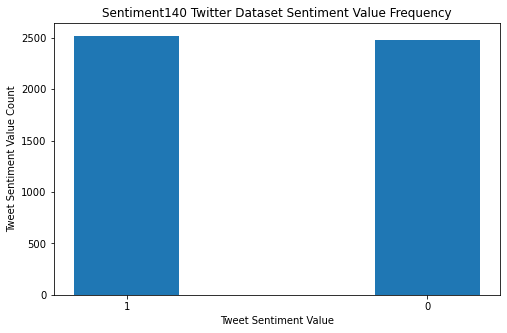

Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0


In [5]:
# Visualization of Dataset Sentiment Outcomes - Ensured Even Distribution of Outcomes
sent_count = df_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)
plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())

if dataset==0:
    plt.xlabel('Tweet Sentiment Value')
    plt.ylabel('Tweet Sentiment Value Count')
    plt.title('Sentiment140 Twitter Dataset Sentiment Value Frequency')
else:
    plt.xlabel('Movie Review Sentiment Value')
    plt.ylabel('Movie Review Sentiment Value Count')
    plt.title('Stanford IMBD Movie Review Dataset Sentiment Value Frequency')
plt.show()
print('Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0')

In [6]:
### Function: Encodes Characters in Samples to Numerical Values
    ## Input: SamplesArray: Array of Samples with Characters
    ## Output: X_: Array of Samples with Numberical Values
def charEnc(SamplesArray):
    X_ = []
    for sample in SamplesArray:
            token_item = []
            for letter in sample.lower():
                if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
                    token_item.append(ord(letter) - ord('a') + 11)
                elif ord(letter) >= ord('0') and ord(letter) <= ord('9'):
                    token_item.append(ord(letter) - ord('0') + 1)
                elif letter == ' ':
                    token_item.append(-1)
                else:
                    pass
            X_.append(token_item)
    return X_

# Encode the Samples
if dataset==0:
    Xdf = charEnc(df_downsampled['Tweet'])
else:
    Xdf = charEnc(df_downsampled['Review'])

# Get Final Train/Test Sets:
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(Xdf, df_downsampled['Sentiment'],test_size=.2, random_state=2)
TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)
TrainXdf[0]

[19, 29, -1, 11, -1, 29, 19, 24, 17, 22, 15, -1, 22, 11, 14, 35, -1]

## Pre-Training Initialization
### Item Memory Generation

In [7]:
### Function: Item Memory Generation
    ## Inputs: dim: Number of columns (i.e. length of HV)
    ##         num_char: Number of rows (i.e. number of supported chars)
    ## Output: dictMem: Item Memory containing HVs for each supported char
def itemMemGen(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    dictMem[dictMem == 0] = -1
    return dictMem

# Parameters:
HV_dim = 10000
num_supported_chars = 37

# Item Memory Generation
itemMem = itemMemGen(dim=HV_dim, num_char=num_supported_chars)
itemMem

array([[-1,  1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1,  1,  1],
       [ 1,  1,  1, ...,  1, -1, -1],
       ...,
       [ 1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ...,  1,  1, -1],
       [ 1,  1,  1, ..., -1, -1, -1]])

### Training Functions

In [8]:
### Function: Encodes a Sample into a HV using NGRAM HDC Approach
    ## Inputs: sample:      Training Sample
    ##         itemMem:     Generate Item Memory
    ##         HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ## Output: sample_HV: HV of inputted sample 
def encode(sample, itemMem, HV_dim=10000, n_gram_len=3, window_size=3):
    sample_HV = np.zeros(HV_dim, dtype='int32')

    for ngram_start in range(0, len(sample)-n_gram_len+1, window_size):
        roll_value=n_gram_len-1
        for j in range(n_gram_len):
            letterHV = itemMem[sample[ngram_start + j]]

            if (j==0):
                product = np.roll(letterHV,roll_value)
            elif (j==n_gram_len-1):
                product = product * letterHV
                sample_HV = np.add(sample_HV, product)
            else:
                product = product * np.roll(letterHV, roll_value)
                
            roll_value = roll_value - 1

    HV_avg = np.average(sample_HV)
    sample_HV[sample_HV > HV_avg] = 1
    sample_HV[sample_HV < HV_avg] = -1
    sample_HV[sample_HV == HV_avg] = 0
    return sample_HV

### Function: NGRAM HDC Training Function that creates an Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         HV_dim:      Dimension of HV
    ##         sent_count:  Number of Possible Sentiment Values
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ## Output: assocMem: Associative Memory 
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, window_size):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    sample_idx = 0
    
    for sample in X:
        sample_HV = encode(sample, itemMem, HV_dim, n_gram_len)
        assocMem[Y[sample_idx]] = np.add(assocMem[Y[sample_idx]], sample_HV)
        sample_idx += 1
    return assocMem

### Testing Functions

In [9]:
### Function: Compares Input HV to Class HVs and Returns the Predicted Class
    ## Inputs: assocMem: Model's Associative Memory
    ##         inputHV:  Encoded HV of a sample
    ## Output: pred: the predicted class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

### Function: Tests the NGRAM HDC Model and Returns Accuracy of Model
    ## Inputs: HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Model's Associative Memory
    ##         TestXdf:     Test Samples
    ##         TextYdf:     Sentiment of Test Samples
    ## Output: accuracy: Accuracy of the Model
def test(HV_dim, n_gram_len, window_size, itemMem, assocMem, TestXdf, TestYdf):
    true_pos_count=0
    false_pos_count=0
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, HV_dim, n_gram_len, window_size))
        if (TestYdf[index] == prediction):
            correct_count += 1
            if prediction==1:
                true_pos_count += 1
        elif prediction==1:
            false_pos_count += 1 
            
    accuracy = (correct_count / len(TestYdf)) * 100
    if (true_pos_count+false_pos_count) != 0:
        precision = (true_pos_count/ (true_pos_count+false_pos_count)) * 100
    else:
        precision=0
    return accuracy, precision

## Optimal Hyperparameter Search
### One-Shot Training/Accuracy of Various Sets of Hyperparameter Values

In [10]:
# Hyperparameters
n_gram_lens = [1, 2, 3, 4, 5]
window_sizes = [1, 0] # Option 0 is the current NGRAM length

# Optimal Result Initialization
best_acc=0
n_gram_best=0
window_size_best=0
best_assocMem=[]

# Generate Table Initialization
table_data=[]
col_names = ["NGRAM LEN", "WINDOW SIZE", "ONE-SHOT ACCURACY", "ONE-SHOT-PRECISION", "TRAINING TIME (s)", "NUMBER OF TRAINING SAMPLES", "TESTING TIME (s)", "NUMBER OF TESTING SAMPLES"]

for ngram_len in n_gram_lens:
    for window_size in window_sizes:

        # Option 0:
        if window_size==0:
            window_size=ngram_len

        # Train Model (i.e. Generate Model's Associative Memory)
        t0=time.time()
        assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), ngram_len, window_size=window_size)
        t1=time.time()
        train_time = t1-t0

        # One-Shot Training Results
        t0=time.time()
        one_shot_accuracy, one_shot_precision =test(HV_dim, ngram_len, window_size, itemMem, assocMem, TestXdf, TestYdf)
        t1=time.time()
        test_time = t1-t0

        # Add Data to Table
        data = [ngram_len, window_size, one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
        table_data.append(data)

        if one_shot_accuracy>best_acc:
            best_acc=one_shot_accuracy
            best_assocMem=copy.copy(assocMem)
            n_gram_best=ngram_len
            window_size_best=window_size

# Get Best Assoc Memory
assocMem=copy.copy(best_assocMem)

# Save Results to File
df=pd.DataFrame(table_data, columns=col_names)
filepath="./Results/HyperparameterResults/NGRAM_" + str(dataset) +".csv"
df.to_csv(filepath)

print("Results of Various Hyperparameter Sets")
print(tabulate(table_data, headers=col_names, tablefmt="simple"))
print("\nBest Hyperparameters: NGRAM LEN: ", n_gram_best, ", WINDOW SIZE: ", window_size_best)
print("Best One-Shot Accuracy: ", best_acc)

Results of Various Hyperparameter Sets
  NGRAM LEN    WINDOW SIZE    ONE-SHOT ACCURACY    ONE-SHOT-PRECISION    TRAINING TIME (s)    NUMBER OF TRAINING SAMPLES    TESTING TIME (s)    NUMBER OF TESTING SAMPLES
-----------  -------------  -------------------  --------------------  -------------------  ----------------------------  ------------------  ---------------------------
          1              1                 47.6                0                   2.89146                          4000             3.32816                         1000
          1              1                 47.6                0                   2.57871                          4000             2.90126                         1000
          2              1                 63.5               65.3772              6.03674                          4000             5.12829                         1000
          2              2                 61.5               63.6008              5.18849                     

## Retraining Optimal Model

In [11]:
### Function: NGRAM HDC Re-Training Function that creates a New Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Associative Memory of Current Model
    ##         HV_dim:      Dimension of HV
    ##         n_gram_len:  Length of NGRAM
    ##         window_size: Size of sliding window
    ##         alpha:       Learning Rate Parameter
    ## Output: assocMem: New Associative Memory
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, window_size, alpha):
    sample_index = 0
    for sample in X:
        sample_HV = encode(sample, itemMem, HV_dim, n_gram_len, window_size)
        prediction = get_prediction(assocMem, sample_HV)
        if prediction != Y[sample_index]:
            assocMem[Y[sample_index]] = np.add(assocMem[Y[sample_index]], alpha * sample_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * sample_HV)
        sample_index += 1
    return assocMem

# Re-Train Optimal Model with Learning Parameter
learningparam_results=[]
num_epochs = 20
print('-------- Retraining Model w Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, HV_dim, n_gram_best, window_size_best, alpha = num_epochs - epoch)
    acc, prec = test(HV_dim, n_gram_best, window_size_best, itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    learningparam_results.append([acc,prec])

# Re-Train Optimal Model without Learning Parameter
assocMem=copy.copy(best_assocMem)
no_learningparam_results=[]
print('-------- Retraining Model without Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, HV_dim, n_gram_best, window_size_best, alpha = 1)
    acc, prec = test(HV_dim, n_gram_best, window_size_best, itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    no_learningparam_results.append([acc,prec])

# Save All Results to Files
col_name=["Accuracy", "Precision"]

df_lp=pd.DataFrame(learningparam_results, columns=col_name)
filepath="./Results/EpochResults_LearningParam/NGRAM_" + str(dataset) +".csv"
df_lp.to_csv(filepath)

df_nlp=pd.DataFrame(no_learningparam_results, columns=col_name)
filepath="./Results/EpochResults_NoLearningParam/NGRAM_" + str(dataset) +".csv"
df_nlp.to_csv(filepath)

-------- Retraining Model w Learning Parameter:  20  Epochs --------
Epoch  1 :  64.0
Epoch  2 :  67.10000000000001
Epoch  3 :  67.2
Epoch  4 :  66.9
Epoch  5 :  67.60000000000001
Epoch  6 :  66.4
Epoch  7 :  67.10000000000001
Epoch  8 :  67.30000000000001
Epoch  9 :  66.4
Epoch  10 :  66.9
Epoch  11 :  67.0
Epoch  12 :  67.10000000000001
Epoch  13 :  67.0
Epoch  14 :  67.10000000000001
Epoch  15 :  67.10000000000001
Epoch  16 :  67.10000000000001
Epoch  17 :  67.10000000000001
Epoch  18 :  67.10000000000001
Epoch  19 :  67.10000000000001
Epoch  20 :  67.10000000000001
-------- Retraining Model without Learning Parameter:  20  Epochs --------
Epoch  1 :  67.0
Epoch  2 :  68.60000000000001
Epoch  3 :  66.4
Epoch  4 :  66.3
Epoch  5 :  67.0
Epoch  6 :  66.9
Epoch  7 :  67.80000000000001
Epoch  8 :  68.60000000000001
Epoch  9 :  68.4
Epoch  10 :  67.4
Epoch  11 :  66.3
Epoch  12 :  68.10000000000001
Epoch  13 :  68.8
Epoch  14 :  67.5
Epoch  15 :  68.2
Epoch  16 :  68.4
Epoch  17 :  68.0
